In [16]:
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras import layers, models

In [17]:
# Load the cats vs dogs dataset
(train_ds, validation_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [18]:
# Data preprocessing
IMG_SIZE = 160

def preprocess(image, label):
    # Resize the image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values
    image = image / 255.0
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing to both datasets
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [19]:
model = keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(160, 160, 3)
)

In [20]:
model = models.Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [21]:
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [23]:
# Train the model
epochs = 5
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 453s 764ms/step - accuracy: 0.9169 - loss: 0.2135 - val_accuracy: 0.7375 - val_loss: 2.0683
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 493s 846ms/step - accuracy: 0.9521 - loss: 0.1243 - val_accuracy: 0.7386 - val_loss: 6.3392
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 535s 918ms/step - accuracy: 0.9644 - loss: 0.0960 - val_accuracy: 0.8143 - val_loss: 3.3155
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 528s 908ms/step - accuracy: 0.9725 - loss: 0.0792 - val_accuracy: 0.7524 - val_loss: 4.4141
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 542s 931ms/step - accuracy: 0.9752 - loss: 0.0681 - val_accuracy: 0.9278 - val_loss: 0.7153


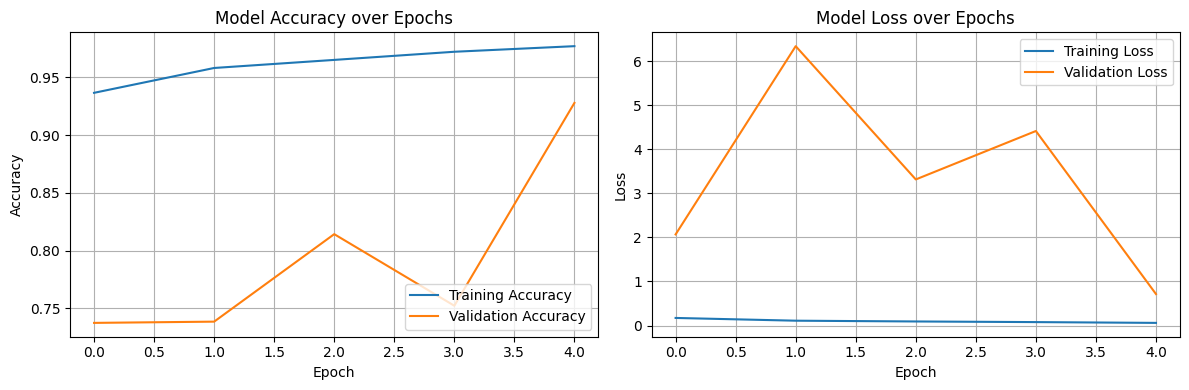


Final Training Metrics:
Training Accuracy: 0.9768
Validation Accuracy: 0.9278
Training Loss: 0.0608
Validation Loss: 0.7153


In [24]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print('\nFinal Training Metrics:')
print(f'Training Accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}')
print(f'Training Loss: {history.history["loss"][-1]:.4f}')
print(f'Validation Loss: {history.history["val_loss"][-1]:.4f}')

Sample predictions on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


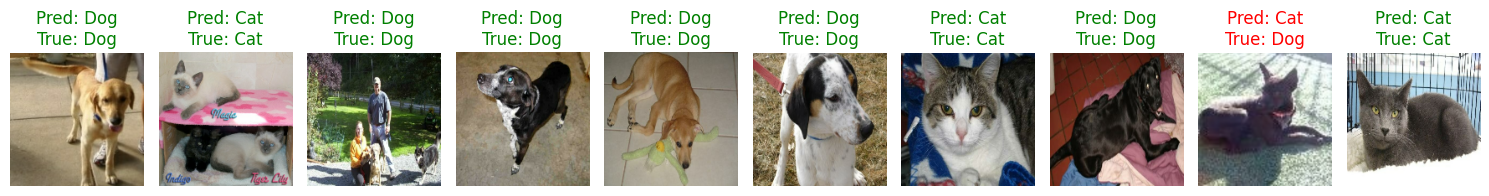

In [25]:
# Visualize some predictions
def plot_predictions(dataset, num_images=5):
    # Get a batch of images
    images, labels = next(iter(dataset.unbatch().batch(num_images)))

    # Make predictions
    predictions = model.predict(images)

    # Plot the images and predictions
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        pred_label = "Dog" if predictions[i] > 0.5 else "Cat"
        true_label = "Dog" if labels[i] == 1 else "Cat"
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation dataset
print("Sample predictions on validation dataset:")
plot_predictions(validation_ds, 10)